# CNN Tutorial - Handwritten Digit Classification on MNIST Dataset

## Importing required libraries

In [1]:
import numpy as np                  # Numerical & Scientific Computing
import pandas as pd                 # Provides 'DataFrame' datastructure for loading & processing datasets
import matplotlib.pyplot as plt     # Visualizations
import seaborn as sns               # Visualizations
import tensorflow as tf             # For building Deep Learning Models, includes Keras

In [2]:
# Check TF Version, GPU usage
print(tf.__version__)
print(tf.test.gpu_device_name())

2.9.2
/device:GPU:0


## Load Dataset

`tf.keras` has a built-in MNIST dataset: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data

- Returns **60000** training images, **10000** testing images (as pixel intensity matrices)

- Handwritten digit images are grayscale images of size **28 x 28** px

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Basic EDA

In [4]:
# see the dataset types, sizes sizes
print(type(x_train), type(y_train), type(x_test), type(y_test))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [5]:
# Function to pretty print an image matrix (for visualization purpose)
# https://stackoverflow.com/a/13214945
def print_image_matrix(matrix):
    s = [[str(e) for e in row] for row in matrix]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print('\n'.join(table))

In [6]:
print('Digit:', y_train[0])
print_image_matrix(x_train[0])

Digit: 5
0	0	0	0	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0	0	0	0
0	0	0	0	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0	0	0	0
0	0	0	0	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0	0	0	0
0	0	0	0	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0	0	0	0
0	0	0	0	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0  	0	0	0	0
0	0	0	0	0  	0  	0  	0  	0  	0  	0  	0  	3  	18 	18 	18 	126	136	175	26 	166	255	247	127	0	0	0	0
0	0	0	0	0  	0  	0  	0  	30 	36 	94 	154	170	253	253	253	253	253	225	172	253	242	195	64 	0	0	0	0
0	0	0	0	0  	0  	0  	49 	238	253	253	253	253	253	253	253	253	251	93 	82 	82 	56 	39 	0  	0	0	0	0
0	0	0	0	0  	0  	0  	18 	219	253	253	253	253	253	198	182	247	241	0  	0  	0  	0  	0  	0  	0	0	0	0
0	0	0	0	0  	0  	0  	0  	80 	156	107	253	253	205	11 	0  	43 	154	0  	0  	0  	0  	0  	0  	0	0	0	0
0	0	0	0	0  	0  	0  	0  	0  	14 

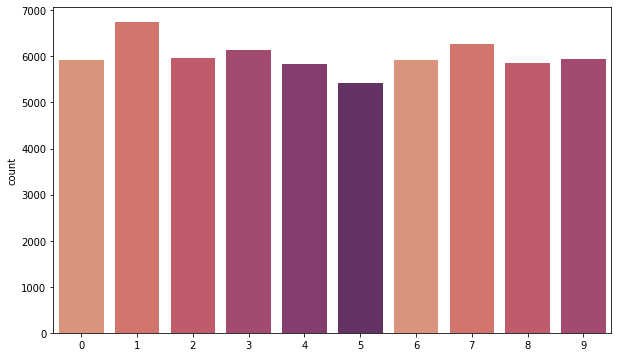

In [7]:
# Visualize distribution of target class in training set
_ = plt.figure(figsize = (10, 6))
sns.countplot(x = y_train, palette = sns.color_palette('flare'))

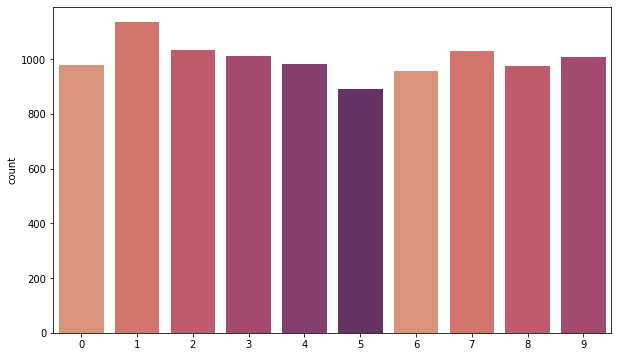

In [8]:
# Visualize distribution of target class in test set
_ = plt.figure(figsize = (10, 6))
sns.countplot(x = y_test, palette = sns.color_palette('flare'))

In [9]:
# functions to plot a single image and to plot a subset of images

import random

def plot_single_digit(img = None, label = None):
    '''
    img -> pixel intensity matrix (a single matrix from x_train or x_test)
    label -> corresponding target label (handwritten digit)
    IF both are None -> a random sample from x_train is selected
    '''
    if img is None:
        ind = random.randint(0, x_train.shape[0] - 1)
        img = x_train[ind]
        label = y_train[ind]
    plt.imshow(img, cmap = 'gray')
    plt.title(f'Digit {label}')

def plot_random_subset():
    fig = plt.figure(figsize = (10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plot_single_digit()
    # for gap between subplots
    plt.subplots_adjust(top = 0.99, bottom = 0.01, hspace = 0.5, wspace = 0.5)

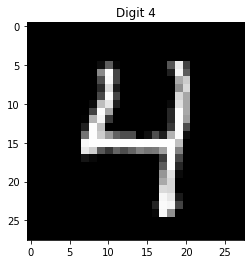

In [10]:
plot_single_digit()

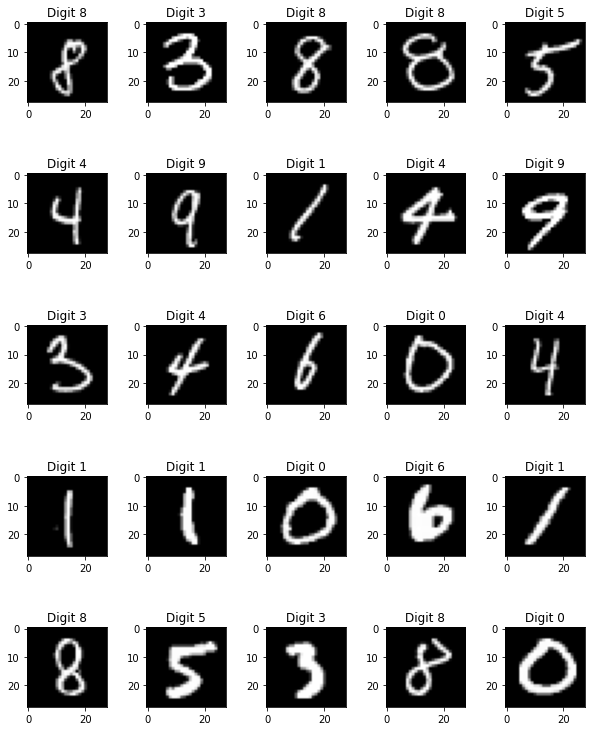

In [11]:
plot_random_subset()

## Data Preprocessing

- Normalization

In [12]:
x_train_scaled = x_train / 255.0
x_test_scaled = x_test / 255.0

In [13]:
print(np.min(x_train), np.max(x_train))
print(np.min(x_test), np.max(x_test))
print(np.min(x_train_scaled), np.max(x_train_scaled))
print(np.min(x_test_scaled), np.max(x_test_scaled))

0 255
0 255
0.0 1.0
0.0 1.0


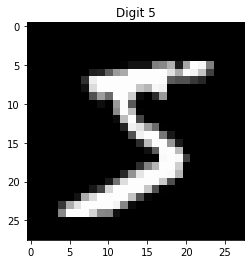

In [14]:
# just for verification
plot_single_digit(x_train[0], y_train[0])

## Creating the Validation Set from the training set

Now, we shall have:
- Training set of 51000 samples
- Validation set of 9000 samples (10% of training set)
- Test set of 10000 samples

&rarr; Validation Set shall be used during training

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(x_train_scaled, y_train, test_size = 0.15, random_state = 42)

In [16]:
print(type(X_train), X_train.shape)
print(type(Y_train), Y_train.shape)
print(type(X_val), X_val.shape)
print(type(Y_val), Y_val.shape)
print(type(x_test_scaled), x_test_scaled.shape)
print(type(y_test), y_test.shape)

<class 'numpy.ndarray'> (51000, 28, 28)
<class 'numpy.ndarray'> (51000,)
<class 'numpy.ndarray'> (9000, 28, 28)
<class 'numpy.ndarray'> (9000,)
<class 'numpy.ndarray'> (10000, 28, 28)
<class 'numpy.ndarray'> (10000,)


## Building the CNN Model

In [17]:
# function to build a model & return it

inputShape = tuple(list(X_train[0].shape) + [1])
numOfClasses = 10

def get_model():
    model = tf.keras.Sequential()

    # Conv2D + MaxPool2D
    model.add(tf.keras.layers.Conv2D(
        filters = 32, kernel_size = (3, 3), padding = 'same', 
        input_shape = inputShape, # FIRST LAYER -> Specify input_shape 
        activation = 'relu'
    ))
    model.add(tf.keras.layers.MaxPool2D(
        pool_size = (2, 2)
    ))

    # Conv2D + MaxPool2D
    model.add(tf.keras.layers.Conv2D(
        filters = 64, kernel_size = (3, 3), padding = 'same', 
        activation = 'relu'
    ))
    model.add(tf.keras.layers.MaxPool2D(
        pool_size = (2, 2)
    ))

    # Conv2D + MaxPool2D
    model.add(tf.keras.layers.Conv2D(
        filters = 64, kernel_size = (3, 3), padding = 'same', 
        activation = 'relu'
    ))
    model.add(tf.keras.layers.MaxPool2D(
        pool_size = (2, 2)
    ))

    # Dropout
    model.add(tf.keras.layers.Dropout(rate = 0.2))

    # Flatten
    model.add(tf.keras.layers.Flatten())

    # ANN (Fully Connected Units)
    model.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    model.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))

    # Output Layer (Linear Activation instead of Softmax)
    model.add(tf.keras.layers.Dense(units = numOfClasses, activation = 'linear'))
    
    print(model.summary())

    return model

In [18]:
model_1 = get_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

In [19]:
# Train the model
model_1.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

model_1_history = model_1.fit(
    X_train, Y_train,
    epochs = 10,
    validation_data = (X_val, Y_val)
)

Epoch 1/10
1594/1594 [==============================] - 16s 8ms/step - loss: 0.1863 - accuracy: 0.9395 - val_loss: 0.0585 - val_accuracy: 0.9821
Epoch 2/10
1594/1594 [==============================] - 9s 6ms/step - loss: 0.0566 - accuracy: 0.9817 - val_loss: 0.0391 - val_accuracy: 0.9886
Epoch 3/10
1594/1594 [==============================] - 7s 4ms/step - loss: 0.0408 - accuracy: 0.9871 - val_loss: 0.0438 - val_accuracy: 0.9869
Epoch 4/10
1594/1594 [==============================] - 7s 4ms/step - loss: 0.0345 - accuracy: 0.9889 - val_loss: 0.0347 - val_accuracy: 0.9901
Epoch 5/10
1594/1594 [==============================] - 7s 4ms/step - loss: 0.0263 - accuracy: 0.9918 - val_loss: 0.0323 - val_accuracy: 0.9904
Epoch 6/10
1594/1594 [==============================] - 7s 4ms/step - loss: 0.0240 - accuracy: 0.9920 - val_loss: 0.0386 - val_accuracy: 0.9906
Epoch 7/10
1594/1594 [==============================] - 7s 4ms/step - loss: 0.0217 - accuracy: 0.9929 - val_loss: 0.0301 - val_accuracy

## Evaluate the Model

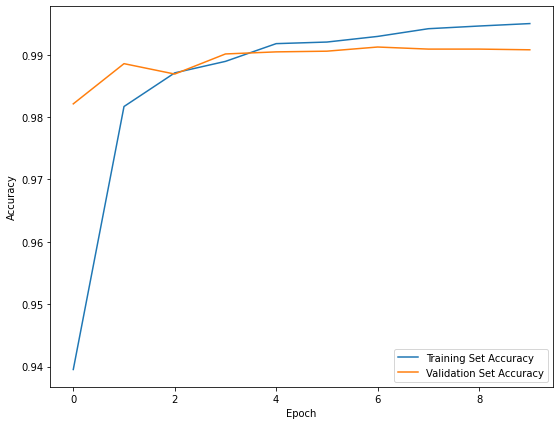

In [20]:
# Plot Training set accuracy v/s Validation set accuracy
fig = plt.figure(figsize = (9, 7))
plt.plot(model_1_history.history['accuracy'], label = 'Training Set Accuracy')
plt.plot(model_1_history.history['val_accuracy'], label = 'Validation Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')

In [21]:
# Predict Test Set Accuracy
test_loss, test_acc = model_1.evaluate(x_test_scaled, y_test)
print(test_loss, test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0337 - accuracy: 0.9909
0.03374026343226433 0.9908999800682068


In [22]:
# Predicting Test Set results
proba_model = tf.keras.Sequential([
    model_1,
    tf.keras.layers.Softmax()
])

y_pred_proba = proba_model.predict(x_test_scaled)

y_pred = []
for tmp in y_pred_proba:
    y_pred.append(np.argmax(tmp))

print(y_pred[100], y_test[100])

313/313 [==============================] - 1s 2ms/step
6 6


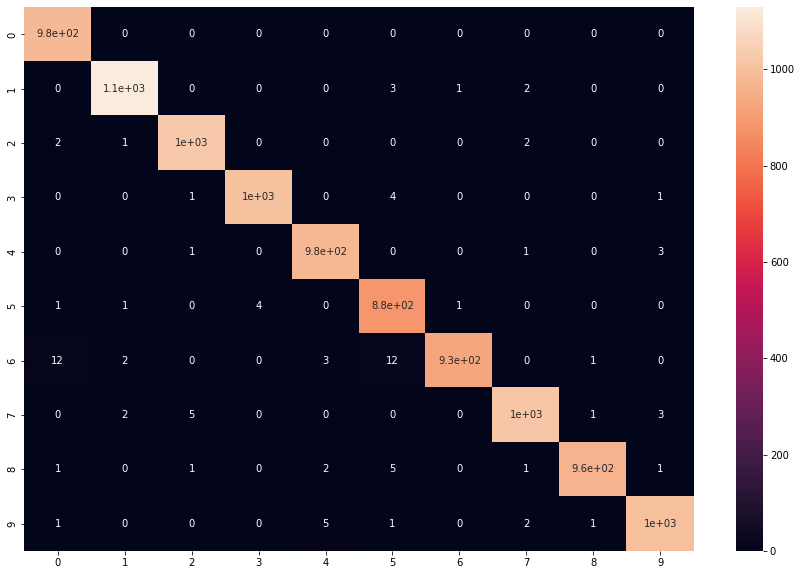

In [23]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

_ = plt.figure(figsize = (15, 10))
sns.heatmap(cm, annot = True)

In [24]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      1.00      0.99      1032
           3       1.00      0.99      1.00      1010
           4       0.99      0.99      0.99       982
           5       0.97      0.99      0.98       892
           6       1.00      0.97      0.98       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

